# USING RANDOM FORESTS

30/01/2020 - Davide di Nello - ECB S2S Training


In [1]:
print(__doc__)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.inspection import plot_partial_dependence
from collections import OrderedDict
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

Automatically created module for IPython interactive environment


## Import  and prepare Titanic dataset

Data can be fetched via openml, or downloaded manually from https://www.openml.org/d/40945 <br>
When importing data manually, we first need to clean some of it to be sure that values are interpreted correctly <br>
Also, we will generate two random features, in order to see their effect on Random Forest

In [2]:
#X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True) # gives proxy problems
df = pd.read_csv('phpMYEkMl.csv')  # Manual import of the file

y = df.survived 
X = df.drop('survived', axis=1)

df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
X[X == '?'] = np.nan  # Missing values are represented by a question mark - replace them with NaN
X.age = X.age.astype(float)  # Some numeric variables were interpreted as strings because of missing values. 
X.fare = X.fare.astype(float) # Transform them back to numeric

**Feature Selection:** <br>
We remove useless predictors: name, ticket and destination are by definition sparse and bring no information. <br> Boat and body, on the other hand, are perfectly correlated on our target variable "survived".

In [4]:
# Generate two random predictors, to see their effect on feature importances
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

# Separate categorical and numerical predictors for preprocessing
categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]


**Data preparation:** <br>
For categorical variables: Impute missing as a new category and encode numerically <br>
For numerical variables: Impute missing with the mean<br>



In [5]:
X[categorical_columns] = X[categorical_columns].fillna('missing') 
oe = OrdinalEncoder().fit(X[categorical_columns])
X[categorical_columns] = oe.transform(X[categorical_columns])

for elem in numerical_columns:
    X[elem] = X[elem].fillna(X[elem].mean()) 

In [6]:
# Split Train and test data, stratifying over the target class

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

## Using sklearn's RandomForestClassifier
Let's try first to use it with default parameters:

In [7]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.814


**Hyperparameters Optimization:** <br>
Let's take advantage of the Out Of Bag error of Random Forest to estimate the best parameters. <br>
We can try multiple values of `max_features` and `max_depth` and at the same time check the progress of the OOB score as we grow more and more trees. <p>
We will check OOB error while growing from 10 to 500 trees in the Random Forest, testing the algorithm on a discrete grid over `max_features: [sqrt(n), n/2, n]` and `max_depth: [5, 10, None]`

In [8]:
max_feat = ["sqrt", 0.5, None]
depth = [5, 10, None]

ensemble_clfs = [("RF, max_features={}, max_depth={}".format(x,y),
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features=x,
                               random_state=42,
                               max_depth=y)) for x in max_feat for y in depth]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in tqdm(range(min_estimators, max_estimators + 1, 10)):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

100%|██████████████████████████████████████████| 50/50 [00:07<00:00,  6.35it/s]


**Let's plot these OOB errors:**

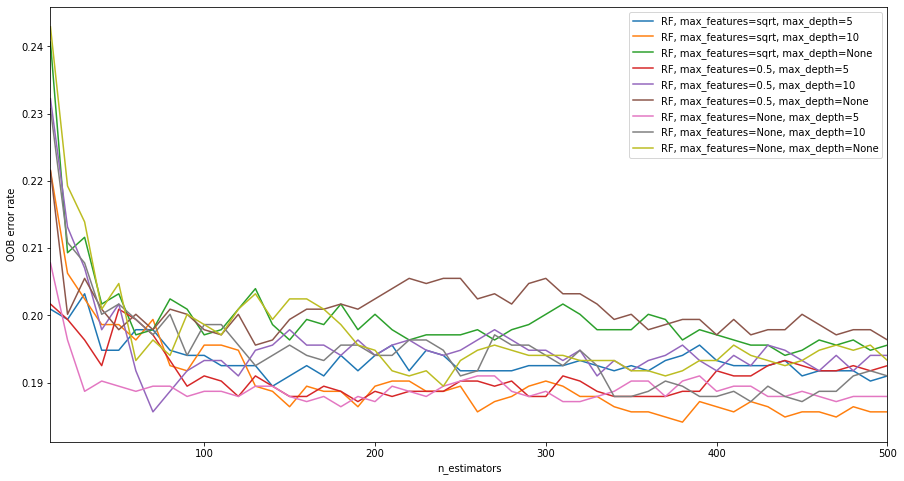

In [9]:
plt.figure(figsize=(15,8))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

It looks like the best option is to use `max_features=None`, and its OOB error looks stable from around `n_estimators=200`. <br>
Therefore, let's use these parameters for our model!

In [10]:
rf = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators=200, max_depth=10)
rf.fit(X_train, y_train)
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 0.939
RF test accuracy: 0.851


## Interpretability: Variable Importances and Dependency plots
Every implementation of Random Forest allows access to Variable Importances. <br>
These are computed by summing all the impurity decreases that were encountered when doing a split on a given variable.<br>
Let's see what they look like:

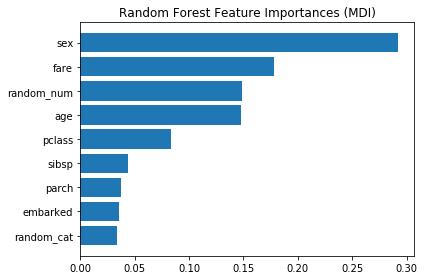

In [11]:
tree_feature_importances = (
    rf.feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(X.columns))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(X.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

How is it possible that the importance of the random numerical predictor is so high?
<p>
**Permutation Importance:** <br>
Instead of looking at the impurity when building the trees, let's see how the performance changes over the test set when shuffling a variable!

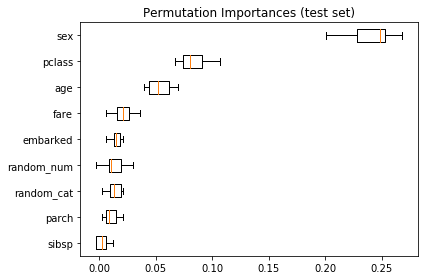

In [12]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=1, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

It is however important to only trust your variable importances if your model is strong enough. If your model is weak and generalizes badly, importances have usually little meaning and they might fluctuate importantly from one run to another.

We now know which features are the most important. <br>
But can we also know do they affect the chance of survival? <p>
**Partial Dependency Plots:** <br>
These plots marginalize the contributions of the single variables and give us an idea of how each variable impacts the output. <br>
Bear in mind, however, that these relationships are just descriptive and assume independence between the plotted variable and the others, so handle with care!

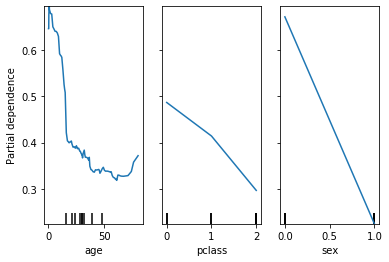

In [13]:
features = ['age', 'pclass', 'sex']
plot_partial_dependence(rf, X, features)

When checking the inverse transformation of our classes, we see that values [0,1,2] for pclass correspond to 1st, 2nd and 3rd class, while for sex, 0 represents female and 1 represents males. <p>
**All together, if you were on the Titanic, you'd have had the highest chance of survival by being a baby girl in 1st class!**

In [19]:
logreg = LogisticRegression().fit(X,y)

In [23]:
accuracy_score(logreg.predict(X_test), y_test)

0.8140243902439024